In [7]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
# import constants_sf as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

analysis_year = 2017
us_ton_to_ton = 0.907185
miles_to_km = 1.60934
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)
shipment_value_attr = 'value_' + str(analysis_year)

plot_dir = 'plots_Seattle'
output_dir = 'outputs_Seattle'
input_dir = 'inputs_Seattle'

In [2]:
# set plot params
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")
sns.set_theme(style="white", font_scale=1.4)

In [3]:
#load modeled, FAF and CFS results

faf_data = read_csv('Validation/' + 'FAF5.3.csv', sep = ',')
production_file = 'synthetic_producers.csv'
modeled_production = read_csv(os.path.join(output_dir, production_file))
print(modeled_production.columns)

consumption_file = 'synthetic_consumers.csv'
modeled_consumption = read_csv(os.path.join(output_dir, consumption_file))
print(modeled_consumption.columns)

zonal_file = 'zonal_id_lookup_final.csv'
zonal_id_lookup = read_csv(os.path.join(input_dir, zonal_file))
zonal_id_lookup.head(5)

Index(['SellerID', 'Zone', 'NAICS', 'Commodity_SCTG', 'Size',
       'OutputCapacitylb', 'NonTransportUnitCost'],
      dtype='object')
Index(['NAICS', 'InputCommodity', 'Commodity_SCTG', 'Zone', 'Buyer.SCTG',
       'BuyerID', 'Size', 'ConVal', 'PurchaseAmountlb'],
      dtype='object')


,GEOID,CBPZONE,MESOZONE,FAFID,FAFNAME
0,530559601001,53055,3312.0,539,Rest of WA
1,530330293053,53033,1923.0,531,Seattle
2,530330205002,53033,1429.0,531,Seattle
3,530770028021,53077,4720.0,539,Rest of WA
4,530530620003,53053,2850.0,531,Seattle


In [17]:
# mesozone in study area
region_code = [531, 532, 539, 411] 
zonal_id_selected = \
zonal_id_lookup.loc[zonal_id_lookup['FAFID'].isin(region_code)]
list_of_zones = zonal_id_selected['MESOZONE'].unique()
print(list_of_zones[0:5])

[3312. 1923. 1429. 4720. 2850.]


In [4]:
# cleaning -- removing international firms and re-calculate production value

modeled_production.loc[:, 'ProdVal'] = \
modeled_production.loc[:, 'OutputCapacitylb'] * \
modeled_production.loc[:, 'NonTransportUnitCost'] / 10 ** 6

print('production value before and after dropping international:')
print(modeled_production.loc[:, 'ProdVal'].sum())
modeled_production = \
modeled_production.loc[modeled_production['Zone'] < 30000]
print(modeled_production.loc[:, 'ProdVal'].sum())

print('consumption value before and after dropping international:')
print(modeled_consumption.loc[:, 'ConVal'].sum())
modeled_consumption = \
modeled_consumption.loc[modeled_consumption['Zone'] < 30000]
print(modeled_consumption.loc[:, 'ConVal'].sum())

production value before and after dropping international:
14683035.103969714
13132301.890880251
consumption value before and after dropping international:
11779803.131391123
11061641.55055941


In [8]:
# processing the faf data
trade_type_id = 1 # domestic only
faf_data_domestic = \
faf_data.loc[faf_data['trade_type'] == trade_type_id]
print('total production value from faf:')
print(faf_data_domestic[shipment_value_attr].sum())
faf_data_domestic.head(5)

total production value from faf:
15081746.696731


,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2019,tmiles_2020,tmiles_2022,tmiles_2023,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,3.351765,3.398871,3.614785,3.718716,4.364371,5.327137,6.342501,7.763605,9.571647,11.343818
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,50.646235,51.702439,54.030117,55.009694,62.052489,72.493059,82.113979,96.869428,116.602924,134.683927
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.468714,0.476138,0.483170,0.481371,0.486727,0.533539,0.564126,0.638719,0.750361,0.844720
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,2.267241,2.372436,2.359789,2.352784,2.549854,3.018065,3.155784,3.394250,3.850035,4.178881
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,1.327792,1.421785,1.412938,1.412791,1.554450,1.863748,1.969298,2.141527,2.456208,2.683008


In [11]:
modeled_production_by_sctg = \
modeled_production.groupby(['Commodity_SCTG'])[['ProdVal']].sum()

modeled_production_by_sctg = modeled_production_by_sctg.reset_index()
modeled_production_by_sctg.loc[:, 'source'] = 'modeled production'
modeled_consumption_by_sctg = \
modeled_consumption.groupby(['Commodity_SCTG'])[['ConVal']].sum()

modeled_consumption_by_sctg = modeled_consumption_by_sctg.reset_index()
modeled_consumption_by_sctg.loc[:, 'source'] = 'modeled consumption'
faf_value_by_sctg = faf_data_domestic.groupby(['sctg2'])[[shipment_value_attr]].sum()
faf_value_by_sctg = faf_value_by_sctg.reset_index()
faf_value_by_sctg.loc[:, 'source'] = 'FAF5 value'
faf_value_by_sctg.head(5)

,sctg2,value_2017,source
0,1,174599.840998,FAF5 value
1,2,156787.422540,FAF5 value
2,3,333167.354853,FAF5 value
3,4,138668.253471,FAF5 value
4,5,349716.595858,FAF5 value


<Axes: xlabel='SCTG', ylabel='Value'>

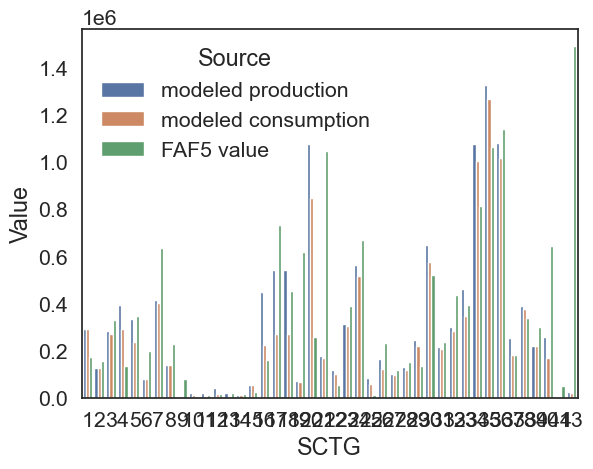

In [13]:
# compare value
col_names = ['SCTG', 'Value', 'Source']
modeled_production_by_sctg.columns = col_names
modeled_consumption_by_sctg.columns = col_names
faf_value_by_sctg.columns = col_names

national_value_to_compare = \
pd.concat([modeled_production_by_sctg,
           modeled_consumption_by_sctg,
           faf_value_by_sctg])


[43, 36, 35, 21, 34, 17, 24, 40, 7, 19, 30, 18, 32, 33, 23]


<Axes: xlabel='SCTG', ylabel='Value'>

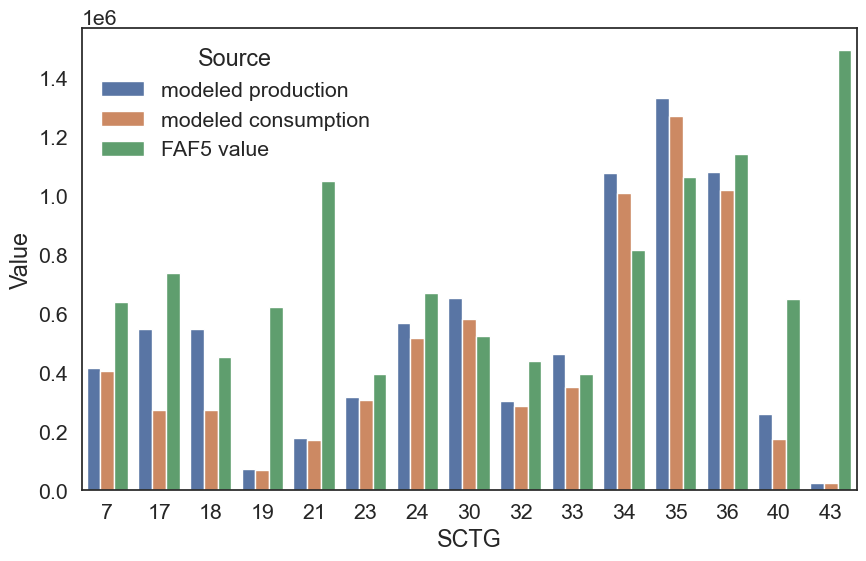

In [16]:
# plot top 10 commodity
faf_value_by_sctg = faf_value_by_sctg.sort_values(by = 'Value',
                                                 ascending = False)
top_sctg = faf_value_by_sctg.head(15)['SCTG'].tolist()
print(top_sctg)
national_value_to_compare_top = \
national_value_to_compare.loc[national_value_to_compare['SCTG'].isin(top_sctg)]
plt.figure(figsize = (10, 6))
sns.barplot(national_value_to_compare_top,
            x = 'SCTG', y = 'Value', hue = 'Source',
            errorbar = None)

In [20]:
# compare results for selected region
region_modeled_production = \
modeled_production.loc[modeled_production['Zone'].isin(list_of_zones)]
region_production_by_sctg = \
region_modeled_production.groupby(['Commodity_SCTG'])[['ProdVal']].sum()
region_production_by_sctg = region_production_by_sctg.reset_index()
region_production_by_sctg.loc[:, 'source'] = 'modeled production'

region_modeled_consumption = \
modeled_consumption.loc[modeled_consumption['Zone'].isin(list_of_zones)]
region_consumption_by_sctg = \
region_modeled_consumption.groupby(['Commodity_SCTG'])[['ConVal']].sum()
region_consumption_by_sctg = region_consumption_by_sctg.reset_index()
region_consumption_by_sctg.loc[:, 'source'] = 'modeled consumption'

faf_data_region_prod = \
faf_data_domestic.loc[faf_data_domestic['dms_orig'].isin(region_code)]

faf_data_region_cons = \
faf_data_domestic.loc[faf_data_domestic['dms_dest'].isin(region_code)]

faf_region_prod_by_sctg = \
faf_data_region_prod.groupby(['sctg2'])[[shipment_value_attr]].sum()
faf_region_prod_by_sctg = faf_region_prod_by_sctg.reset_index()
faf_region_prod_by_sctg.loc[:, 'source'] = 'FAF5 production'
# faf_region_prod_by_sctg.head(5)

faf_region_cons_by_sctg = \
faf_data_region_cons.groupby(['sctg2'])[[shipment_value_attr]].sum()
faf_region_cons_by_sctg = faf_region_cons_by_sctg.reset_index()
faf_region_cons_by_sctg.loc[:, 'source'] = 'FAF5 production'
faf_region_cons_by_sctg.head(5)

,sctg2,value_2017,source
0,1,2915.172571,FAF5 production
1,2,6741.448954,FAF5 production
2,3,18113.399920,FAF5 production
3,4,3081.014371,FAF5 production
4,5,12148.200922,FAF5 production


Regional production modeled:
344601.6251083225
FAF production modeled:
436652.546812
[43, 40, 35, 21, 37, 7, 17, 19, 3, 34, 26, 38, 36, 30, 24]


<Axes: xlabel='SCTG', ylabel='Value'>

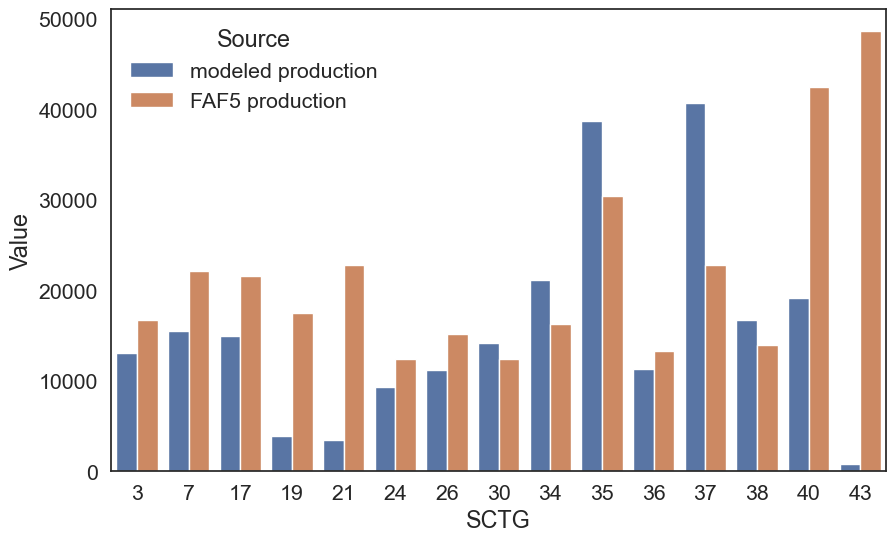

In [23]:
# regional production
col_names = ['SCTG', 'Value', 'Source']
region_production_by_sctg.columns = col_names
faf_region_prod_by_sctg.columns = col_names

print('Regional production modeled:')
print(region_production_by_sctg.Value.sum())
print('FAF production modeled:')
print(faf_region_prod_by_sctg.Value.sum())

regional_production_to_compare = \
pd.concat([region_production_by_sctg,
           faf_region_prod_by_sctg])

faf_region_prod_by_sctg = \
faf_region_prod_by_sctg.sort_values(by = 'Value', ascending = False)
top_sctg = faf_region_prod_by_sctg.head(15)['SCTG'].tolist()
print(top_sctg)
regional_production_to_compare_top = \
regional_production_to_compare.loc[regional_production_to_compare['SCTG'].isin(top_sctg)]
plt.figure(figsize = (10, 6))
sns.barplot(regional_production_to_compare_top,
            x = 'SCTG', y = 'Value', hue = 'Source',
            errorbar = None)

Regional consumption modeled:
313656.77739332087
FAF consumption modeled:
451227.66166200006
[43, 35, 40, 21, 34, 17, 7, 19, 36, 37, 3, 30, 24, 26, 38]


<Axes: xlabel='SCTG', ylabel='Value'>

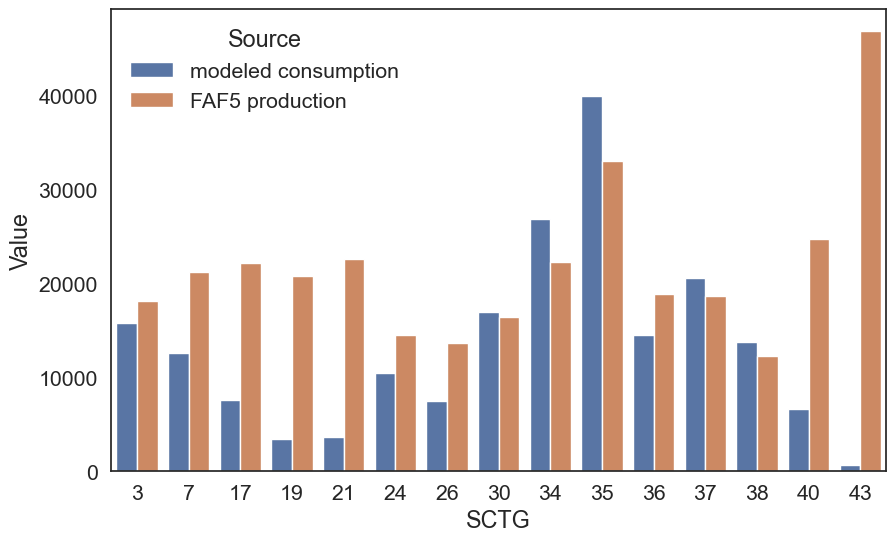

In [24]:
# regional consumption
col_names = ['SCTG', 'Value', 'Source']
region_consumption_by_sctg.columns = col_names
faf_region_cons_by_sctg.columns = col_names

print('Regional consumption modeled:')
print(region_consumption_by_sctg.Value.sum())
print('FAF consumption modeled:')
print(faf_region_cons_by_sctg.Value.sum())

regional_cons_to_compare = \
pd.concat([region_consumption_by_sctg,
           faf_region_cons_by_sctg])

faf_region_cons_by_sctg = \
faf_region_cons_by_sctg.sort_values(by = 'Value', ascending = False)
top_sctg = faf_region_cons_by_sctg.head(15)['SCTG'].tolist()
print(top_sctg)
regional_cons_to_compare_top = \
regional_cons_to_compare.loc[regional_cons_to_compare['SCTG'].isin(top_sctg)]
plt.figure(figsize = (10, 6))
sns.barplot(regional_cons_to_compare_top,
            x = 'SCTG', y = 'Value', hue = 'Source',
            errorbar = None)

In [25]:
# checking mixed freight from CFS
CFS_df = pd.read_csv('RawData/CFS/cfs-2017-puf-csv.csv', sep = ',')
print(len(CFS_df))
print(CFS_df.columns)

5978523
Index(['SHIPMT_ID', 'ORIG_STATE', 'ORIG_MA', 'ORIG_CFS_AREA', 'DEST_STATE',
       'DEST_MA', 'DEST_CFS_AREA', 'NAICS', 'QUARTER', 'SCTG', 'MODE',
       'SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST_GC', 'SHIPMT_DIST_ROUTED',
       'TEMP_CNTL_YN', 'EXPORT_YN', 'EXPORT_CNTRY', 'HAZMAT', 'WGT_FACTOR'],
      dtype='object')


In [31]:
# processing mixed freight from CFS
# no export
CFS_df = CFS_df.loc[CFS_df['EXPORT_YN'] == 'N'] 

CFS_df.loc[:,'WGT_VALUE'] = \
CFS_df.loc[:,'SHIPMT_VALUE'] * CFS_df.loc[:,'WGT_FACTOR']/ 1000000
CFS_to_check = CFS_df.loc[CFS_df['SCTG'] == '43']
# IN MILLION$
print(CFS_to_check.loc[:,'WGT_VALUE'].sum())
mixed_freight_by_naics = \
CFS_to_check.groupby('NAICS')[['WGT_VALUE']].sum()
mixed_freight_by_naics = \
mixed_freight_by_naics.sort_values(by = 'WGT_VALUE', 
                                   ascending = False)
mixed_freight_by_naics.head(10)

1435050.5632075001


,WGT_VALUE
NAICS,
4931,569948.121440
4244,412509.925337
4249,104431.657598
4237,48410.738942
311,46969.927754
4242,42109.776956
551114,35836.797296
4234,34568.431299
4541,29945.167003


In [32]:
CFS_to_check = CFS_df.loc[CFS_df['SCTG'] == '40']
# IN MILLION$
print(CFS_to_check.loc[:,'WGT_VALUE'].sum())
mixed_freight_by_naics = \
CFS_to_check.groupby('NAICS')[['WGT_VALUE']].sum()
mixed_freight_by_naics = \
mixed_freight_by_naics.sort_values(by = 'WGT_VALUE', 
                                   ascending = False)
mixed_freight_by_naics.head(10)

557090.1144121002


,WGT_VALUE
NAICS,
4541,121251.971655
4239,75098.632043
332,48062.807996
4931,41400.102210
339,40139.593820
4238,28713.354626
333,21674.532659
4234,17788.230142
326,13182.190076


In [34]:
# check total warehouse output
CFS_to_check = CFS_df.loc[CFS_df['NAICS'] == 4931]
print(CFS_to_check['WGT_VALUE'].sum())

1164591.2814389002


In [35]:
CFS_df['NAICS'].unique()

array([   326,   4541,   4231,    212,  45431,   4239,   4238,    333,
         4234,    322,    334,   4931,   5111,   4237,    325,    332,
          323,   4244,   4235,   4236,   4247,   4242,    336,    311,
         4241,   4243,   4248,    337,    331,   4233,   4232,   4249,
          339,    327,    321,    313,   4246,    314,    316,    335,
       551114,    312,    324,   4245,    315])

In [56]:
import numpy as np

modeled_production.loc[:, 'NAICS3'] = \
modeled_production.loc[:, 'NAICS'].str[0:3]
modeled_production.loc[:, 'NAICS4'] = \
modeled_production.loc[:, 'NAICS'].str[0:4]

naics3_list = ['326', '212', '333', '322', '334', '325', '332',
               '323', '336', '311', '337', '331', '339', '327',    
               '321', '313', '314', '316', '335', '312', '324', 
               '315' ]
modeled_production.loc[:, 'NAICS_CFS'] = np.nan

naics3_index = (modeled_production['NAICS3'].isin(naics3_list))
modeled_production.loc[naics3_index, 'NAICS_CFS'] = \
modeled_production.loc[naics3_index, 'NAICS3'].astype(int)

naics4_list = ['4541', '4231', '4239', '4238', '4234', '4931', 
               '5111', '4237', '4244', '4235', '4236', '4247',   
               '4242', '4241', '4243', '4248', '4233', '4232',   
               '4249', '4246', '4245']

naics4_index = (modeled_production['NAICS4'].isin(naics4_list))
modeled_production.loc[naics4_index, 'NAICS_CFS'] = \
modeled_production.loc[naics4_index, 'NAICS4'].astype(int)

other_index = (modeled_production['NAICS3'] == '484')
modeled_production.loc[other_index, 'NAICS_CFS'] = 4931

other_index = (modeled_production['NAICS'] == '484')
modeled_production.loc[other_index, 'NAICS_CFS'] = 4931
modeled_production.head(5)

,SellerID,Zone,NAICS,Commodity_SCTG,Size,OutputCapacitylb,NonTransportUnitCost,ProdVal,NAICS3,NAICS4,NAICS_CFS
0,1,20001,113000,25,4.333333,29514340.68,0.098623,2.91079,113,1130,NaN
1,2,20001,113000,25,4.333333,29514340.68,0.098623,2.91079,113,1130,NaN
2,3,20001,113000,25,4.333333,29514340.68,0.098623,2.91079,113,1130,NaN
3,4,20001,113000,25,4.333333,29514340.68,0.098623,2.91079,113,1130,NaN
4,5,20001,113000,25,4.333333,29514340.68,0.098623,2.91079,113,1130,NaN


In [55]:
modeled_production.loc[:, 'NAICS3'].unique()

array(['113', '114', '115', '211', '212', '311', '312', '313', '314',
       '315', '316', '321', '322', '323', '324', '325', '326', '327',
       '331', '332', '333', '334', '335', '336', '337', '339', '511',
       '111', '112', '424', '423', '425', nan], dtype=object)

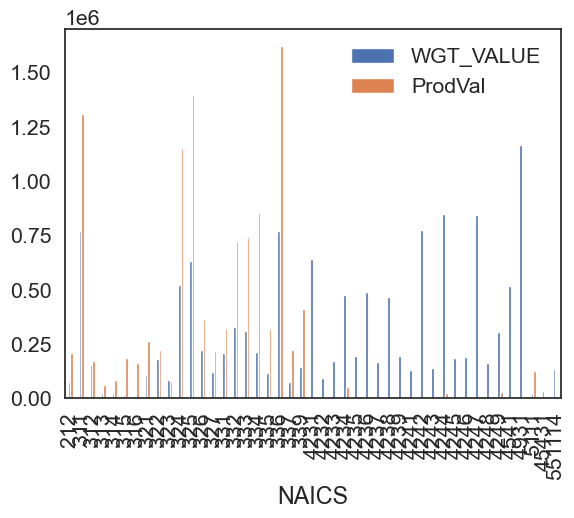

In [63]:
CFS_value_by_naics = CFS_df.groupby('NAICS')[['WGT_VALUE']].sum()
CFS_value_by_naics = CFS_value_by_naics.reset_index()
CFS_value_by_naics

modeled_production_to_compare = \
modeled_production.loc[~modeled_production['NAICS_CFS'].isna()]
modeled_value_by_naics = \
modeled_production_to_compare.groupby('NAICS_CFS')[['ProdVal']].sum()
modeled_value_by_naics = modeled_value_by_naics.reset_index()
modeled_value_by_naics
CFS_value_compare = pd.merge(CFS_value_by_naics,
                             modeled_value_by_naics,
                             left_on = 'NAICS', right_on = 'NAICS_CFS',
                             how = 'left')

CFS_value_compare.head(10)
CFS_value_compare = CFS_value_compare.drop(columns = ['NAICS_CFS'])
CFS_value_compare.plot(x='NAICS', kind = 'bar')
CFS_value_compare.to_csv('Validation/compare_value_cfs.csv')

In [65]:
cfs_commodity_by_naics = \
CFS_df.groupby(['SCTG','NAICS'])[['WGT_VALUE']].sum()
cfs_commodity_by_naics = cfs_commodity_by_naics.reset_index()
cfs_commodity_by_naics.to_csv('Validation/cfs_value_by_sctg_naics.csv',
                             index = False)